In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread
from collections import Counter
from torch.utils.data import DataLoader
import torch
from data import MovieLensSequenceDataset
from movielens_transformer import MovieLensTransformer, MovieLensTransformerConfig, TransformerConfig
from dacite import from_dict
import pprint


## Movielens Dataset

Let's start with reading and exploring the dataset

In [2]:
users = pd.read_csv(
    "./data/ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={"user_id": np.int32, "sex": "category", "age_group": "category", "occupation": "category", "zip_code": str},
)

ratings = pd.read_csv(
    "./data/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={"user_id": np.int32, "movie_id": np.int32, "rating": np.int8, "unix_timestamp": np.int32},
)

movies = pd.read_csv(
    "./data/ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={"movie_id": np.int32, "title": str, "genres": str},
)

In [3]:
users.head()

,user_id,sex,age_group,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In a separate csv, we also have links to the movie posters just to add a little bit more flare to the exploration

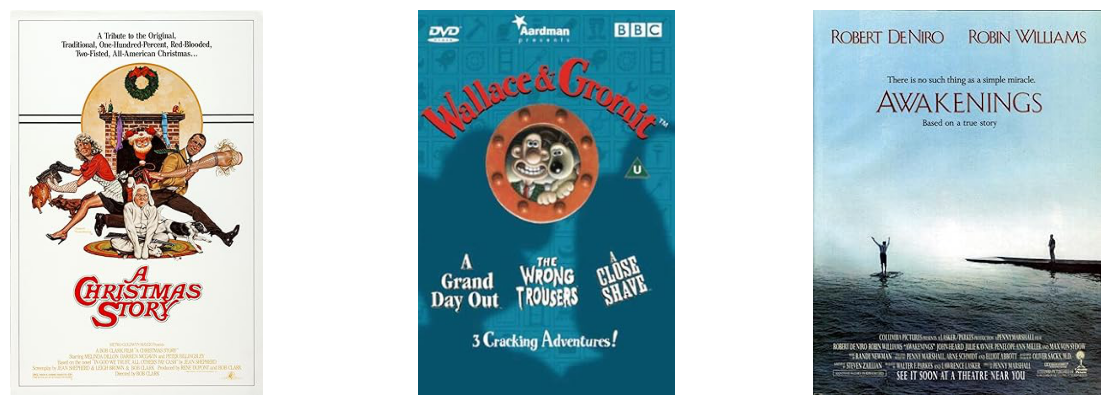

In [6]:
image_urls = pd.read_csv("./data/movie_poster_1m.csv", index_col="item_id")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (ax, img) in enumerate(zip(axs.flat, image_urls.iloc[[7, 10, 17], 0].values)):
    ax.imshow(imread(img))  # Display the image
    ax.axis('off')  # Turn off axis
plt.show()

## Tokenization

Let's now tokenize the user_ids and movie_ids such that both map on to 0:N space, where N is the number of unique entities.

In [7]:
# user ids
unique_user_ids = users["user_id"].unique()
unique_user_ids.sort()

# movie ids
unique_movie_ids = movies["movie_id"].unique()
unique_movie_ids.sort()

# tokenization
user_id_tokens = {user_id: i for i, user_id in enumerate(unique_user_ids)}
movie_id_tokens = {movie_id: i for i, movie_id in enumerate(unique_movie_ids)}

## Sequence Generation

In [8]:
ratings["user_id_tokens"] = ratings["user_id"].map(user_id_tokens)
ratings["movie_id_tokens"] = ratings["movie_id"].map(movie_id_tokens)

In [9]:
ratings_ordered = ratings[["user_id_tokens", "movie_id_tokens", "unix_timestamp", "rating"]].sort_values(
    by="unix_timestamp").groupby("user_id_tokens").agg(list).reset_index()

In [10]:
ratings_ordered

,user_id_tokens,movie_id_tokens,unix_timestamp,rating
0,0,"[3117, 1672, 1250, 1009, 2271, 1768, 3339, 118...","[978300019, 978300055, 978300055, 978300055, 9...","[4, 4, 5, 5, 3, 5, 4, 4, 5, 4, 3, 5, 4, 4, 4, ..."
1,1,"[1180, 1199, 1192, 2648, 1273, 2874, 1207, 117...","[978298124, 978298151, 978298151, 978298196, 9...","[4, 3, 4, 3, 5, 4, 5, 5, 5, 4, 4, 2, 5, 4, 4, ..."
2,2,"[589, 2789, 3465, 1899, 1892, 1407, 1246, 3602...","[978297018, 978297039, 978297068, 978297068, 9...","[3, 4, 3, 4, 4, 3, 5, 5, 4, 5, 4, 5, 4, 4, 4, ..."
3,3,"[1192, 1081, 476, 3399, 3458, 1178, 257, 1180,...","[978293924, 978293964, 978294008, 978294008, 9...","[3, 4, 4, 5, 1, 2, 5, 5, 5, 5, 5, 5, 4, 5, 5, ..."
4,4,"[2648, 907, 896, 352, 1230, 2119, 2789, 1111, ...","[978241072, 978241072, 978241072, 978241112, 9...","[1, 4, 4, 1, 5, 1, 4, 1, 2, 3, 5, 4, 4, 3, 5, ..."
...,...,...,...,...
6035,6035,"[1672, 1814, 3369, 2307, 2359, 2614, 2503, 263...","[956709349, 956709350, 956709350, 956709350, 9...","[4, 4, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 1, 5, 4, ..."
6036,6036,"[1813, 693, 1247, 1959, 3439, 3079, 558, 847, ...","[956708997, 956708997, 956708997, 956708997, 9...","[1, 2, 5, 4, 3, 4, 4, 5, 5, 4, 3, 4, 3, 4, 5, ..."
6037,6037,"[3327, 908, 1192, 2077, 1366, 352, 1063, 1132,...","[956706827, 956706827, 956706876, 956706909, 9...","[3, 3, 4, 4, 2, 4, 5, 5, 3, 3, 4, 4, 5, 4, 5, ..."
6038,6038,"[109, 279, 1998, 1211, 918, 935, 3019, 2953, 3...","[956705158, 956705158, 956705178, 956705202, 9...","[4, 4, 4, 3, 4, 3, 5, 4, 3, 3, 4, 2, 3, 2, 4, ..."


In [11]:
sequence_length = 5
min_sequence_length = 1
window_size = 1

Let's first generate a sequence for one user_id and make sure we generate the correct sequences. Then we can expand that to all the data.

In [12]:
sample_data = ratings_ordered.iloc[0]
sample_movie_ids = torch.tensor(sample_data.movie_id_tokens, dtype=torch.int32)
sample_ratings = torch.tensor(sample_data.rating, dtype=torch.int8)
sample_movie_sequences = sample_movie_ids.ravel().unfold(0, sequence_length, 1).to(torch.int32)
sample_rating_sequences = sample_ratings.ravel().unfold(0, sequence_length, 1).to(torch.int8)

In [13]:
sample_movie_sequences

tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189],
        [2271, 1768, 3339, 1189, 2735],
        [1768, 3339, 1189, 2735,  257],
        [3339, 1189, 2735,  257,  711],
        [1189, 2735,  257,  711, 1176],
        [2735,  257,  711, 1176,  907],
        [ 257,  711, 1176,  907,  604],
        [ 711, 1176,  907,  604, 2623],
        [1176,  907,  604, 2623, 1892],
        [ 907,  604, 2623, 1892, 1959],
        [ 604, 2623, 1892, 1959, 3036],
        [2623, 1892, 1959, 3036,  926],
        [1892, 1959, 3036,  926, 1022],
        [1959, 3036,  926, 1022, 1893],
        [3036,  926, 1022, 1893, 1015],
        [ 926, 1022, 1893, 1015, 1949],
        [1022, 1893, 1015, 1949,  148],
        [1893, 1015, 1949,  148, 1081],
        [1015, 1949,  148, 1081,  902],
        [1949,  148, 1081,  902, 1267],
        [ 148, 1081,  902, 1267, 2728],
        [1081,  902, 1267, 2728, 1226],


In [14]:
sample_rating_sequences

tensor([[4, 4, 5, 5, 3],
        [4, 5, 5, 3, 5],
        [5, 5, 3, 5, 4],
        [5, 3, 5, 4, 4],
        [3, 5, 4, 4, 5],
        [5, 4, 4, 5, 4],
        [4, 4, 5, 4, 3],
        [4, 5, 4, 3, 5],
        [5, 4, 3, 5, 4],
        [4, 3, 5, 4, 4],
        [3, 5, 4, 4, 4],
        [5, 4, 4, 4, 5],
        [4, 4, 4, 5, 5],
        [4, 4, 5, 5, 5],
        [4, 5, 5, 5, 4],
        [5, 5, 5, 4, 5],
        [5, 5, 4, 5, 4],
        [5, 4, 5, 4, 5],
        [4, 5, 4, 5, 4],
        [5, 4, 5, 4, 5],
        [4, 5, 4, 5, 4],
        [5, 4, 5, 4, 3],
        [4, 5, 4, 3, 5],
        [5, 4, 3, 5, 4],
        [4, 3, 5, 4, 4],
        [3, 5, 4, 4, 4],
        [5, 4, 4, 4, 3],
        [4, 4, 4, 3, 4],
        [4, 4, 3, 4, 4],
        [4, 3, 4, 4, 4],
        [3, 4, 4, 4, 4],
        [4, 4, 4, 4, 5],
        [4, 4, 4, 5, 3],
        [4, 4, 5, 3, 3],
        [4, 5, 3, 3, 4],
        [5, 3, 3, 4, 4],
        [3, 3, 4, 4, 4],
        [3, 4, 4, 4, 5],
        [4, 4, 4, 5, 3],
        [4, 4, 5, 3, 5],


In [15]:
def generate_sequences(row, sequence_length, window_size):
    movie_ids = torch.tensor(row.movie_id_tokens, dtype=torch.int32)
    ratings = torch.tensor(row.rating, dtype=torch.int8)
    movie_sequences = movie_ids.ravel().unfold(0, sequence_length, window_size).to(torch.int32)
    rating_sequences = ratings.ravel().unfold(0, sequence_length, window_size).to(torch.int8)
    return (movie_sequences, rating_sequences)

In [16]:
for i, row in ratings_ordered.iterrows():
    movie_sequences, rating_sequences = generate_sequences(row, sequence_length, window_size)
    print(movie_sequences)
    print(rating_sequences)
    break

tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189],
        [2271, 1768, 3339, 1189, 2735],
        [1768, 3339, 1189, 2735,  257],
        [3339, 1189, 2735,  257,  711],
        [1189, 2735,  257,  711, 1176],
        [2735,  257,  711, 1176,  907],
        [ 257,  711, 1176,  907,  604],
        [ 711, 1176,  907,  604, 2623],
        [1176,  907,  604, 2623, 1892],
        [ 907,  604, 2623, 1892, 1959],
        [ 604, 2623, 1892, 1959, 3036],
        [2623, 1892, 1959, 3036,  926],
        [1892, 1959, 3036,  926, 1022],
        [1959, 3036,  926, 1022, 1893],
        [3036,  926, 1022, 1893, 1015],
        [ 926, 1022, 1893, 1015, 1949],
        [1022, 1893, 1015, 1949,  148],
        [1893, 1015, 1949,  148, 1081],
        [1015, 1949,  148, 1081,  902],
        [1949,  148, 1081,  902, 1267],
        [ 148, 1081,  902, 1267, 2728],
        [1081,  902, 1267, 2728, 1226],


Let us convert all the scrappy code into a proper `Dataset` class. We will call this `MovieLensSequenceDataset`.

In [17]:
dataset = MovieLensSequenceDataset(
    movies_file="./data/ml-1m/movies.dat",
    users_file="./data/ml-1m/users.dat",
    ratings_file="./data/ml-1m/ratings.dat",
    sequence_length=5,
    window_size=1,
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
batch = next(iter(dataloader))
for t in batch:
    print(t)
    print(t.shape)
    print("-----------------------------------")

2024-08-18 22:46:30.607 | INFO     | data:_read_data:44 - Reading data from files
2024-08-18 22:46:32.170 | INFO     | data:_add_tokens:106 - Adding tokens to data
2024-08-18 22:46:32.213 | INFO     | data:_generate_sequences:116 - Generating sequences


tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189]], dtype=torch.int32)
torch.Size([4, 5])
-----------------------------------
tensor([[4, 4, 5, 5, 3],
        [4, 5, 5, 3, 5],
        [5, 5, 3, 5, 4],
        [5, 3, 5, 4, 4]], dtype=torch.int8)
torch.Size([4, 5])
-----------------------------------
tensor([0, 1, 2, 3], dtype=torch.int32)
torch.Size([4])
-----------------------------------
tensor([1768, 3339, 1189, 2735], dtype=torch.int32)
torch.Size([4])
-----------------------------------
tensor([5, 4, 4, 5], dtype=torch.int8)
torch.Size([4])
-----------------------------------


## Model Definition

Let build the transformer based recommendation model now. We can reuse most of the code that I wrote for my previous post on [Exploring GPT](https://www.kapilsharma.dev/posts/exploring-gpt2/). We will skip defining the `CausalMultiHeadAttention`, `MLP`, `TransformerEncoderLayer` (defined as `GPT2Layer` in previous post), and `Transformer` (defined as `GPT2` in the previous post). Instead, let me just show the differences between what the GPT2 for language model defined vs here.

We will skip the `output_layer` in the `Transformer` i.e. just remove it. We need an interaction layer between the movies and users in rec sys model. Hence, the output layer will be after the interaction. This interaction layer will be defined as an MLP (similar to the one we defined in [DLRM exploration](https://www.kapilsharma.dev/posts/cuda-mode-fusing-kernels-talk/)). 

```python
class InteractionMLP(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int):
        super(InteractionMLP, self).__init__()
        fc_layers = []
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                fc_layers.append(nn.Linear(input_size, hidden_size))
            else:
                fc_layers.append(nn.Linear(hidden_sizes[i - 1], hidden_size))
            fc_layers.append(nn.ReLU())
        fc_layers.append(
            nn.Linear(
                hidden_sizes[-1] if hidden_sizes else input_size,
                output_size,
                bias=False,
            )
        )
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x: torch.Tensor):
        return self.fc_layers(x)

```

### Final Movielens RecSys Model

```python
class MovieLensTransformer(nn.Module):
    def __init__(self, config: MovieLensTransformerConfig):
        super().__init__()
        self.movie_transformer = Transformer(config.movie_transformer_config)
        self.user_embedding = nn.Embedding(
            config.num_users, config.user_embedding_dimension
        )

        self.output_layer = InteractionMLP(
            config.movie_transformer_config.embedding_dimension
            + config.user_embedding_dimension,
            config.interaction_mlp_hidden_sizes,
            config.movie_transformer_config.vocab_size,
        )

    def forward(self, movie_ids: torch.Tensor, user_ids: torch.Tensor):
        movie_embeddings = self.movie_transformer(movie_ids)
        user_embeddings = self.user_embedding(user_ids)
        embeddings = torch.cat([movie_embeddings, user_embeddings], dim=-1)
        return self.output_layer(embeddings)  # returns logits
```


## Testing

Next, let's test the model that we defined to see if we can run a sample batch through it.

In [18]:
movie_ids, ratings, user_ids, output_movie_ids, output_ratings = batch

In [19]:
movie_ids

tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189]], dtype=torch.int32)

In [20]:
user_ids

tensor([0, 1, 2, 3], dtype=torch.int32)

In [21]:
config_json = {
    "movie_transformer_config" : {
        "vocab_size": len(dataset.metadata.movie_id_tokens),
        "context_window_size": 5,
        "embedding_dimension": 32,
        "num_layers": 2,
        "num_heads": 2,
        "dropout_embeddings": 0.1,
        "dropout_attention": 0.1,
        "dropout_residual": 0.1,
        "layer_norm_epsilon": 1e-5,
    },
    "user_embedding_dimension": 32,
    "num_users": len(dataset.metadata.user_id_tokens),
    "interaction_mlp_hidden_sizes": [16],
}

config = from_dict(data_class=MovieLensTransformerConfig, data=config_json)
pprint.pprint(config)


MovieLensTransformerConfig(movie_transformer_config=TransformerConfig(vocab_size=3883,
                                                                      context_window_size=5,
                                                                      embedding_dimension=32,
                                                                      num_layers=2,
                                                                      num_heads=2,
                                                                      dropout_embeddings=0.1,
                                                                      dropout_attention=0.1,
                                                                      dropout_residual=0.1,
                                                                      layer_norm_epsilon=1e-05),
                           user_embedding_dimension=32,
                           num_users=6040,
                           interaction_mlp_hidden_sizes=[16])


In [22]:
model = MovieLensTransformer(config)
model

MovieLensTransformer(
  (movie_transformer): Transformer(
    (token_embedding): Embedding(3883, 32)
    (positional_embedding): Embedding(5, 32)
    (embedding_dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attention): CausalMultiHeadAttention(
          (qkv): Linear(in_features=32, out_features=96, bias=True)
          (out): Linear(in_features=32, out_features=32, bias=True)
          (residual_dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=32, out_features=128, bias=True)
          (activation): GELU(approximate='tanh')
          (fc2): Linear(in_features=128, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (layer_norm): LayerNorm((32,), eps=1e-05

In [23]:
logits = model(movie_ids=movie_ids, user_ids=user_ids)
logits.shape

torch.Size([4, 5, 3883])

We are able to run the model end to end! Now, let's setup the weight initialization for the model. 